In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

import torch
from torch import nn

## Создадим класс Model, в котором создадим архитектуру автокодировщика

In [2]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(7, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
            nn.ReLU(),
            nn.Linear(3, 2),
            nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 7),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Приведем датасет pandas к Tensor виду

In [3]:
train_dataset = pd.read_csv('train.csv', index_col=False)
test_dataset = pd.read_csv('test.csv', index_col=False)

In [4]:
from torch.utils.data import TensorDataset, DataLoader

train_tensorset = torch.Tensor(train_dataset.values[:, :-1])
test = torch.Tensor(test_dataset.values[:, :-1])

train_size = int(len(train_tensorset) * 0.9)
val_size = len(train_tensorset) - train_size

train, val = torch.utils.data.random_split(train_tensorset, [train_size, val_size], generator=torch.Generator().manual_seed(42))


## Функция evaluete для подсчета функции ошибки

In [5]:
def evaluate(model, criterion, test_set, batch_size=1):
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    losses = []
    for data in test_loader:
        with torch.no_grad():
            inputs = data[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
        losses.append(loss.item())
    return losses

## Запишем функцию train

In [6]:
def train_autoencoder(model, criterion, optimizer, train_dataset, val_dataset, epochs):
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    losses_epoch = []
    val_loss = []
    
    model.train(True)
    for epoch in tqdm(range(epochs)):
        for batch in train_loader:
            inputs = batch[0]
            
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        loss_val_epoch = evaluate(model, criterion, val_dataset, 16)
        loss_val_epoch = np.mean(loss_val_epoch)
        
        print('Val loss:', loss_val_epoch.item())
        val_loss.append(loss_val_epoch)
        
        losses_epoch.append(loss.item())
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
    return model, losses_epoch, val_loss

## Зададим функцию ошибки, optimizer, запустим функцию train

In [7]:
AE = Model()
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(AE.parameters(), lr=1e-4, weight_decay=1e-8, amsgrad=True)

model, losses_epoch, val_loss = train_autoencoder(AE, criterion, optimizer, train, val, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

Val loss: 0.6936462699477353
Epoch 1/15, Loss: 0.6927567720413208
Val loss: 0.663676540353405
Epoch 2/15, Loss: 0.6624985933303833
Val loss: 0.6290067576650363
Epoch 3/15, Loss: 0.6277996897697449
Val loss: 0.5889697573078212
Epoch 4/15, Loss: 0.5884567499160767
Val loss: 0.5436667773260999
Epoch 5/15, Loss: 0.54201740026474
Val loss: 0.49805538956798723
Epoch 6/15, Loss: 0.4907306730747223
Val loss: 0.4407449724958904
Epoch 7/15, Loss: 0.43548712134361267
Val loss: 0.4005260881203324
Epoch 8/15, Loss: 0.3861854374408722
Val loss: 0.3453519878102772
Epoch 9/15, Loss: 0.3230651319026947
Val loss: 0.303809722412878
Epoch 10/15, Loss: 0.2738446295261383
Val loss: 0.25358665745649767
Epoch 11/15, Loss: 0.23635616898536682
Val loss: 0.21020552716148433
Epoch 12/15, Loss: 0.21531033515930176
Val loss: 0.18537130084500383
Epoch 13/15, Loss: 0.17661882936954498
Val loss: 0.16299190138702963
Epoch 14/15, Loss: 0.16766497492790222
Val loss: 0.17452087598060495
Epoch 15/15, Loss: 0.14381004869937

## Выведем соотношение значения loss и эпох на валидации и train  

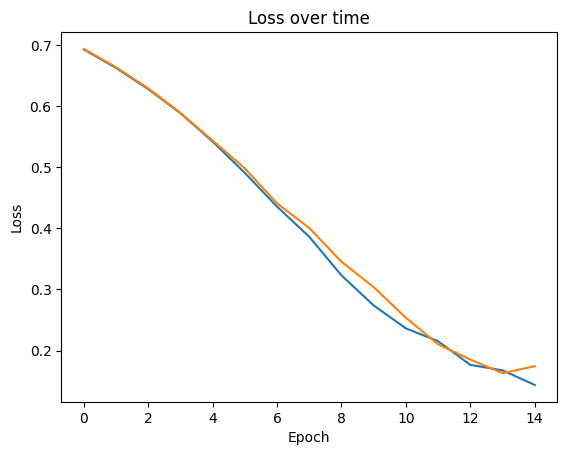

In [8]:
plt.plot(losses_epoch, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
losses_train = evaluate(model, criterion, train)
losses_train_len = len(losses_train)

losses_norma = evaluate(model, criterion, val)
losses_norma_len = len(losses_norma)

losses_attack = evaluate(model, criterion, test)
losses_attack_len = len(losses_attack)

losses = losses_train + losses_norma + losses_attack

## Найдем Threshold для порога аномальности

In [10]:
def set_threshold(model, criterion, tensorset):
    tensor_loader = DataLoader(tensorset, batch_size=1)
    model.eval()
    train_losses = []
    for batch in tensor_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_losses.append(loss.item())
    
    mean_loss = np.mean(train_losses)
    std_loss = np.std(train_losses)
    
    threshold = mean_loss + 1.5 * std_loss
    
    return threshold

threshold = set_threshold(model, criterion, val)
threshold

0.2885040186137392

## Выведем график со значениями ошибки на train, test и валидационном сете

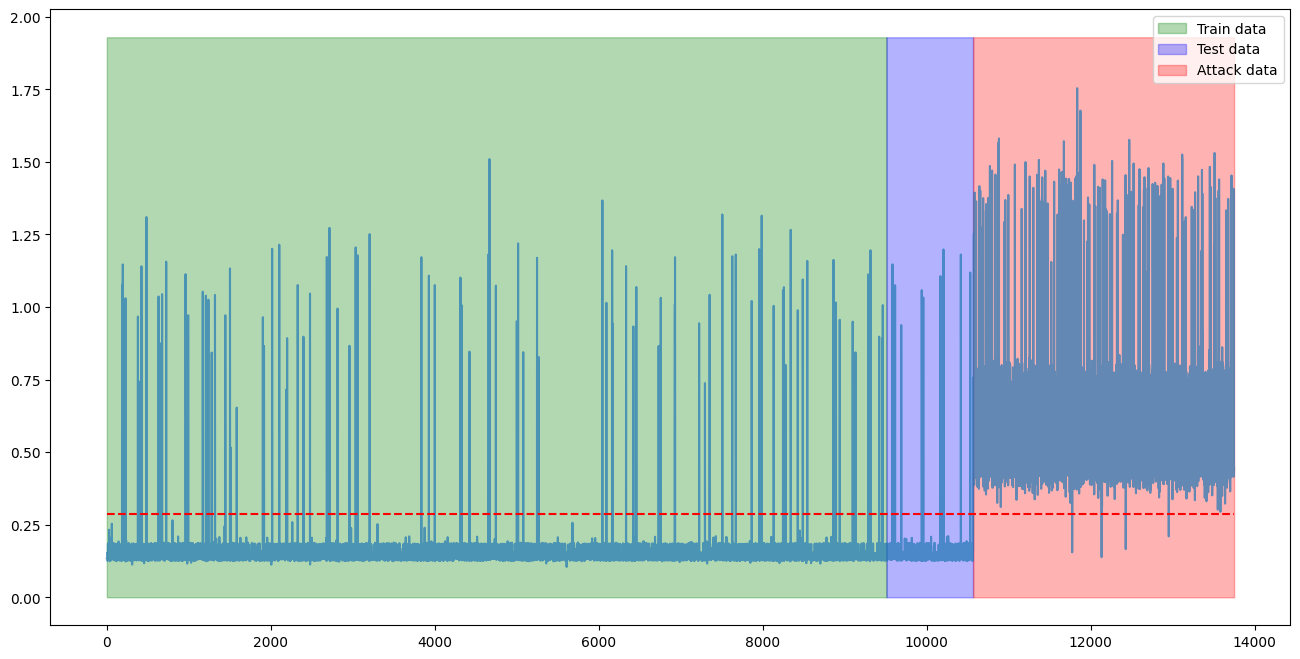

In [11]:
x = np.linspace(0, len(losses), len(losses))
y = losses
max_y = max(y) + 0.1*max(y)

plt.figure(figsize=(16, 8))
plt.plot(x, y, alpha=0.7)
plt.plot([0, len(x)], [threshold, threshold], color='red', linestyle='--')

plt.fill_between(x, max_y, where=(x < losses_train_len + 1), color='green', alpha=0.3, label='Train data')
plt.fill_between(x, max_y, where=(x >= losses_train_len) & (x < losses_train_len + losses_norma_len), color='blue', alpha=0.3, label='Test data')
plt.fill_between(x, max_y, where=(x >= losses_train_len + losses_norma_len), color='red', alpha=0.3, label='Attack data')

plt.legend()
plt.show()

## Посчитаем на основе выбранного порога accuracy, precision, recall и f1score

In [12]:
def evaluate_threshold(threshold, losses_train, losses_norma, losses_attack):
    TP = np.sum(losses_attack > threshold) 
    FP = np.sum(losses_norma > threshold) + np.sum(losses_train > threshold)
    TN = np.sum(losses_norma <= threshold) + np.sum(losses_train <= threshold)
    FN = np.sum(losses_attack <= threshold)

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1_score}")

    return {"TP": TP, "FP": FP, "TN": TN, "FN": FN, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 score": f1_score}

## Выведем confussion matrix

In [13]:
import seaborn as sns

def plot_confusion_matrix(results):
    confusion_matrix = np.array([[results['TN'], results['FP']],
                                 [results['FN'], results['TP']]])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks([0.5, 1.5], labels=['Normal', 'Attack'])
    plt.yticks([0.5, 1.5], labels=['Normal', 'Attack'], va='center')
    plt.show()

Accuracy: 0.9922181818181818
Precision: 0.9686262564727384
Recall: 0.9987437185929648
F1 score: 0.983454461110252


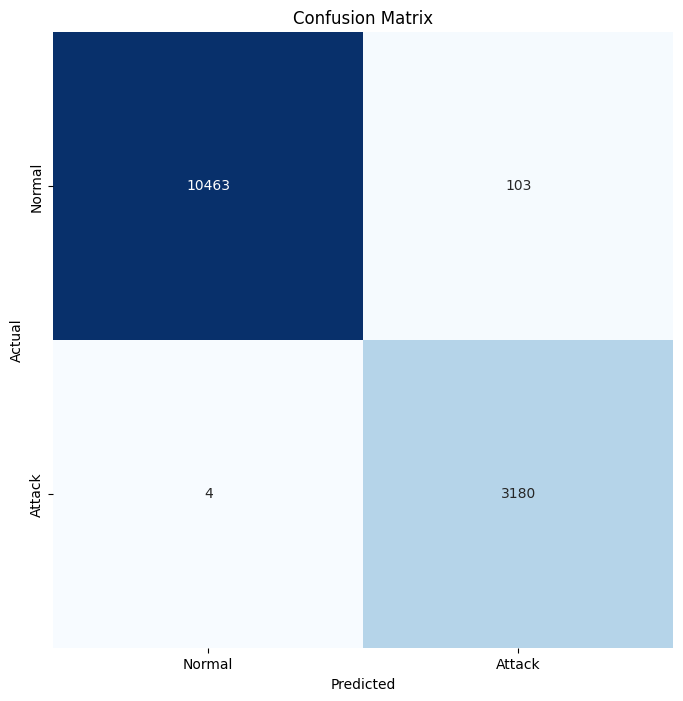

In [14]:
results = evaluate_threshold(threshold, losses_train, losses_norma, losses_attack)
plot_confusion_matrix(results)